<a href="https://colab.research.google.com/github/sunnyinAI/Diffusion_DisparitySum/blob/main/diffuse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Training configuration

For convenience, create a `TrainingConfig` class containing the training hyperparameters (feel free to adjust them):

In [2]:
from dataclasses import dataclass
import torchvision.datasets as dset
from client import client


@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 300
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 20
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    input_dir ='./imges'
    output_dir = "./out"  # the model name locally and on the HF Hub

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0


config = TrainingConfig()

TypeError: 'module' object is not callable

## Load the dataset

In [ ]:
from torchvision import transforms  #To load the dataset and to perform the image transformations.
import torch
preprocess = transforms.Compose(
    [
        transforms.Resize(config.image_size,),   #Resizes the image to a specific size
        transforms.CenterCrop(config.image_size), #Crops the center of the image to a specific size.
        #transforms.Lambda(lambda x: x.convert("RGB")),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),

        transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5]),   #Normalizes the image to a standard distribution.
    ]
)
dataset=dset.ImageFolder(root=config.input_dir,transform=preprocess,   )



/tmp/ipykernel_22890/2921278420.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


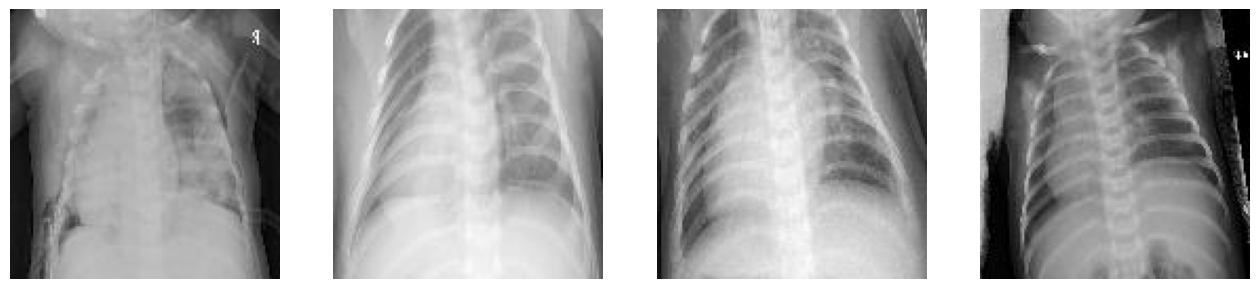

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, (image,l), in enumerate(dataset):    #to iterate over the dataset and to extract the image and label for each iteration.
    axs[i].imshow((image.permute(1,2,0)/2)+0.5)
    axs[i].set_axis_off()
    if i== 3:
        break
fig.show()

In [ ]:
import torch

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

## Create a UNet2DModel

Pretrained models in 🧨 Diffusers are easily created from their model class with the parameters you want. For example, to create a [UNet2DModel](https://huggingface.co/docs/diffusers/main/en/api/models#diffusers.UNet2DModel):

In [ ]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

/home/sunny/Desktop/P5_sum/PneumoniaMNIST/exp_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


It is often a good idea to quickly check the sample image shape matches the model output shape:

In [ ]:
sample_image = dataset[0][0].unsqueeze(0)
print("Input shape:", sample_image.shape)

Input shape: torch.Size([1, 3, 128, 128])


In [ ]:
print("Output shape:", model(sample_image, timestep=0).sample.shape)

Output shape: torch.Size([1, 3, 128, 128])


Great! Next, you'll need a scheduler to add some noise to the image.

## Create a scheduler

The scheduler behaves differently depending on whether you're using the model for training or inference. During inference, the scheduler generates image from the noise. During training, the scheduler takes a model output - or a sample - from a specific point in the diffusion process and applies noise to the image according to a *noise schedule* and an *update rule*.

Let's take a look at the [DDPMScheduler](https://huggingface.co/docs/diffusers/main/en/api/schedulers/ddpm#diffusers.DDPMScheduler) and use the `add_noise` method to add some random noise to the `sample_image` from before:

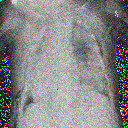

In [ ]:
import torch
from PIL import Image
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

In [ ]:
import torch.nn.functional as F

noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)

## Train the model

By now, you have most of the pieces to start training the model and all that's left is putting everything together.

First, you'll need an optimizer and a learning rate scheduler:

In [ ]:
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

Then, you'll need a way to evaluate the model. For evaluation, you can use the [DDPMPipeline](https://huggingface.co/docs/diffusers/main/en/api/pipelines/ddpm#diffusers.DDPMPipeline) to generate a batch of sample images and save it as a grid:

In [ ]:
from diffusers import DDPMPipeline
import math
import os


def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i % cols * w, i // cols * h))
    return grid


def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
    ).images

    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [ ]:
from accelerate import Accelerator

from tqdm.auto import tqdm
from pathlib import Path
import os


def get_full_repo_name(model_id: str, organization: str = None, token: str = None):
    if token is None:
        token = HfFolder.get_token()
    if organization is None:
        username = whoami(token)["name"]
        return f"{username}/{model_id}"
    else:
        return f"{organization}/{model_id}"


def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:

        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )
    obj=client(url='10.198.63.24:5000')
    global_step = 0
    stop=False
    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            # print(step,batch.shape)
            clean_images = batch[0]
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device
            ).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                if not obj.merge(model):
                    stop=True
                    break

                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                pipeline.save_pretrained(config.output_dir)

        if stop:
            break

In [ ]:
from accelerate import notebook_launcher

args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)


Launching training on one GPU.


/home/sunny/Desktop/P5_sum/PneumoniaMNIST/exp_env/lib/python3.10/site-packages/accelerate/accelerator.py:358: UserWarning: `log_with=tensorboard` was passed but no supported trackers are currently installed.
  warnings.warn(f"`log_with={log_with}` was passed but no supported trackers are currently installed.")


Epoch 299: 100%|██████████| 7/7 [02:28<00:00, 21.28s/it, loss=0.00256, lr=0, step=2099]


Once training is complete, take a look at the final 🦋 images 🦋 generated by your diffusion model!

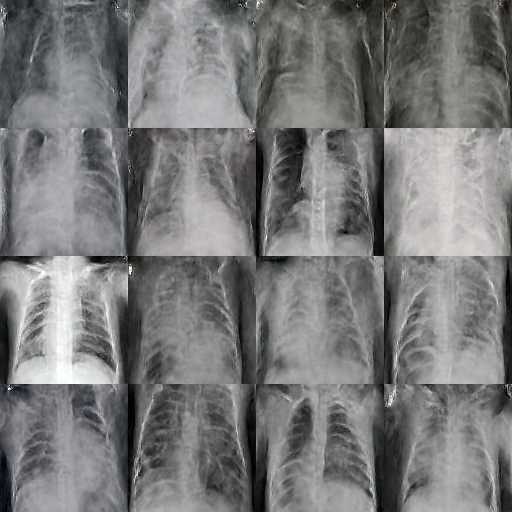

In [ ]:
import glob

sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])